#### Simulating the travelling salesman problem with three cities.

* Importing important libraries

In [1]:
from qiskit import *
from qiskit.circuit import parameter
from qiskit.circuit import ParameterVector, Parameter
from qiskit.visualization import plot_histogram
from IPython.core.display import Latex
from qiskit_algorithms.optimizers import ADAM, COBYLA
from qiskit_algorithms.gradients import SPSAEstimatorGradient
from qiskit_aer import AerSimulator, StatevectorSimulator
from sympy.physics.quantum import TensorProduct
from sympy import Matrix

import numpy as np
import ot
import re
from qiskit.circuit.library.standard_gates import RXGate, RYGate, RZGate, RZZGate

##### n-cycle adjacency matrix

In [2]:
def adjacency_matrix(V, edges):
    # Initialize an empty V x V matrix with all zeros
    matrix = [[0] * V for _ in range(V)]
    
    # Populate the matrix based on the edges
    for edge in edges:
        u, v = edge
        matrix[u][v] = 1
        matrix[v][u] = 1  # Undirected graph
    
    return np.array(matrix)

#### Cost Matrix

In [3]:
# TSP- 3 distance matrix
D = np.array([[0, 2, 3],
                 [2 , 0, 4],
                 [3, 4, 0]])


'Number of Nodes'
V = 3
edges = [(0, 1), (1, 2), (2, 0)]

'Adjacency matrix'
A = adjacency_matrix(V, edges)

'Affinity matrix'
K = TensorProduct(A, D)

### Initial Parameters

In [10]:
n = 3
beta_para = 1.39957953
theta1 = [1.9026521]
theta2 = [2.22944427]
alpha = [5.56530919]

In [5]:
class TSP_Solver:
    def __init__(self, reference_circuit, variational_circuit, MCRX, n, K, theta1, theta2, alpha, loss):
        self.ref_cir = reference_circuit
        self.var_cir = variational_circuit
        self.MCRX = MCRX
        self.n = n
        self.n1 = n*n  # Squared of number of cities
        self.a_m = K   # affinity matrix
        self.alpha = alpha
        self.theta1 = theta1
        self.theta2 = theta2
        self.loss = loss
    
    "Creating an object of encoding layer"
    def encoding_layer(self):
        self.ref_cir.h([q for q in range(self.n1)])  # Applying Hadammard to all qubits
        for i in range(self.n1):
            a = 1                     # var a ensures that only upper-traingle's elements are encoded
            for j in range(self.n1):
                if i == j:
                    self.ref_cir.ry(K[i][j], i)
                    
                elif i != j and i != a:
                    self.ref_cir.append(RZZGate(K[i][j]), [i, a])
                    a += 1
            a += 1

    'Function that return the ctrl qubits for constrained layer'
    def ctrl_qubits(self, matrix, row_idx, col_idx):
        neighbors = []
        num_rows = len(matrix)
        num_cols = len(matrix[0])

        # Add neighbors from the same row
        for j in range(num_cols):
            if j != col_idx:  # Exclude the element itself
                neighbors.append(matrix[row_idx][j])

        # Add neighbors from the same column
        for i in range(num_rows):
            if i != row_idx:  # Exclude the element itself
                neighbors.append(matrix[i][col_idx])

        return neighbors
            
    "Defining contraint layer"
    def constraint_layer(self): 
        matrix = np.array([i for i in range(self.n*self.n)]).reshape(self.n, self.n)
        for i in range(self.n):
            for j in range(self.n):  
                ctrl = list(self.ctrl_qubits(matrix, i, j))+[matrix[i][j]]
                self.var_cir.append(self.MCRX, ctrl)    
        self.var_cir.barrier()
    
    "Perceptron layer"
    def perceptron_layer(self):
        rz = RZGate(self.theta1[0])
        ry = RYGate(self.theta2[0])
        for q in range(self.n1):
            self.var_cir.append(rz, [q])
            self.var_cir.append(ry, [q])
        self.var_cir.barrier()
               
    'Pooling Layer'
    def pooling_layer(self):
        ry = RYGate(self.alpha[0])
        for q in range(self.n1):
            self.var_cir.append(ry, [q])
    
    'composing the reference and variational circuits'
    # The circuit can be visualized as well from here.
    def ansatz(self):
        ansat = self.ref_cir.compose(self.var_cir)
        ansat.measure_all()
        return ansat
    
    'Statvector simulating'
    def statevect(self):
        simulator = Aer.get_backend('statevector_simulator')
        ansatz_trans = transpile(self.ansatz(), AerSimulator())
        result = simulator.run(ansatz_trans).result()
        statevector = result.get_statevector()
        return statevector.draw('latex')
    
    def sinkhorn_normalization(self, matrix, epsilon=1e-3, max_iters=100, constraint_epsilon=1e-9):
        assert matrix.shape[0] == matrix.shape[1], "Input matrix must be square"

        # Get the shape of the matrix
        n = matrix.shape[0]

        # Initialize u and v vectors
        u = np.ones(n)
        v = np.ones(n)

        # Perform Sinkhorn iterations
        for _ in range(max_iters):
            u_new = 1 / (np.dot(matrix, v) + epsilon)
            v_new = 1 / (np.dot(matrix.T, u_new) + epsilon)

            # Check convergence
            if np.allclose(u_new, u) and np.allclose(v_new, v):
                break

            u = u_new
            v = v_new

        # Compute the Sinkhorn normalized matrix
        normalized_matrix = np.diag(u_new) @ matrix @ np.diag(v_new)

        # Apply constraint on zero terms
        normalized_matrix[normalized_matrix < constraint_epsilon] = constraint_epsilon

        # Renormalize the matrix to ensure it remains doubly stochastic
        row_sums = np.sum(normalized_matrix, axis=1)
        col_sums = np.sum(normalized_matrix, axis=0)
        normalized_matrix /= np.sqrt(np.outer(row_sums, col_sums))

        return normalized_matrix

    'Reshaping result to matrix'
    def x_matrix(self):
        latex_string = self.statevect().data     # Stores the statevector as a latex string5
        latex_list = list(latex_string)        # This object stores the statevector as a list
        
        'Extracting only the states of the qubits'
        a = latex_list.index('|')
        b = latex_list.index('\\')
        y = latex_list[a+1:b]
        y1 = np.array([int(i) for i in y])
        y1 = y1[::-1]
        Y1 = y1.reshape(self.n, self.n)  # Reshaping the measured states of qubits to a matrix 

        # Apply Sinkhorn algorithm to converge to a doubly stochastic matrix with the matching constraint
        X_ds = self.sinkhorn_normalization(Y1)
        return X_ds
    
    def cost_fun(self):
        """Cost function of circuit parameters on training data.
            The optimizer will attempt to minimize this."""
        X = list(self.matching_matrix.flatten())
        Y = list(self.x_matrix().flatten())
        for i in range(len(X)):
            self.loss += (-X[i]*np.log(Y[i]) + (1-X[i])*np.log(1-Y[i]))
        return self.loss


#### Calling the whole class here
* Number of Cities 'n'
* Quantum circuit 
* Applying Hadammard to all qubits

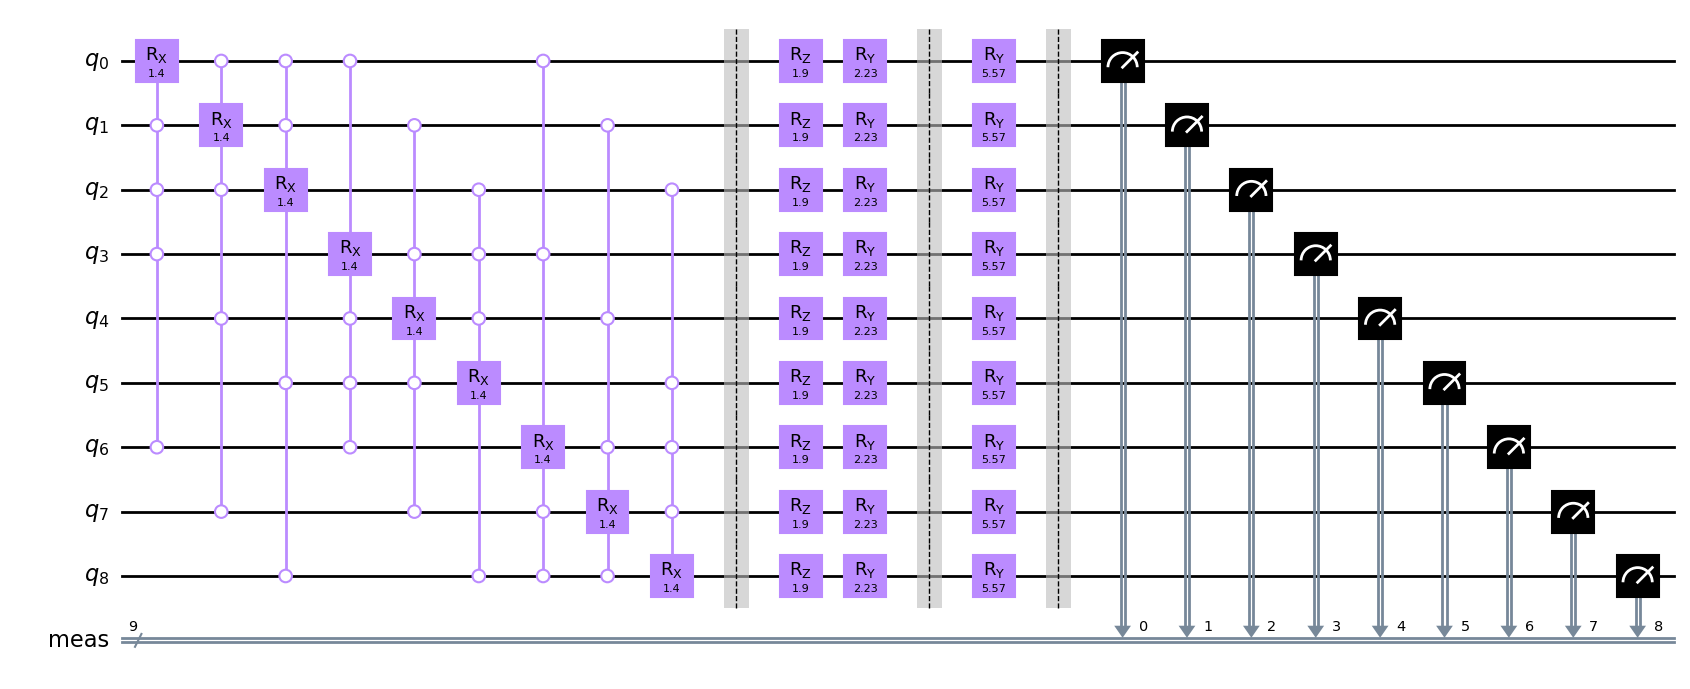

In [11]:
def call_pass_obj_fun(TSP):
#     TSP.encoding_layer()
    TSP.constraint_layer()
    TSP.perceptron_layer()
    TSP.pooling_layer()
    TSP.ansatz()
    
    return TSP.ansatz().draw('mpl')
#     TSP.statevect()
#     TSP.x_matrix()
#     TSP.cost_fun()
#     return TSP.loss


reference_circuit = QuantumCircuit(n*n)      # Circuit to which data be encoded
variational_circuit = QuantumCircuit(n*n)     # Circuit for

loss = 0
MCRX=RXGate(beta_para).control(4, ctrl_state='0000')

TSP = TSP_Solver(reference_circuit, variational_circuit, MCRX, n, K, theta1, theta2, alpha, loss)
call_pass_obj_fun(TSP)

##### Objective function for optimizer

In [36]:
def objective_function(params):

    theta1_values = params[25:50]  # Extract first 9 values for theta1
    theta2_values = params[50:75]  # Extract next 9 values for theta2
    alpha = params[75:100]  # Extract alpha
    beta_para = params[:1]  # Extract beta_para

    # Set theta1 and theta2 values
    TSP.theta1 = theta1_values
    TSP.theta2 = theta2_values
    TSP.alpha = alpha

    # Update the beta_para for MCRX gate
    beta_angle = beta_para[0]  # Assuming you want to use the first value from beta_para
    MCRX = RXGate(beta_angle).control(8, ctrl_state='00000000')
    TSP.MCRX = MCRX
    
    # Run the quantum neural network and compute loss
    obj_loss = call_pass_obj_fun(TSP)
    return obj_loss

##### Gradient for the optimizer


In [37]:
def gradient_function(params):

    epsilon = 1e-6  # pert value

    initial_loss = objective_function(params)

    params_plus = params.copy() + epsilon
    
    loss_plus = objective_function(params_plus)
    
    gradient = (loss_plus - initial_loss) / epsilon

    return gradient

In [38]:

initial_point = np.array([beta_para for i in range(n*n)]+[theta1[0] for i in range(n*n)]+
                         [theta2[0] for i in range(n*n)]+[alpha[0] for i in range(n*n)])

# Instantiate Adam optimizer
adam_optimizer = ADAM(maxiter= 5, tol=1e-06, lr=0.1, beta_1=0.9,
                      beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=False, snapshot_dir=None)

# Run optimization
result = adam_optimizer.minimize(objective_function, initial_point, gradient_function)
result.x

array([1.39957953, 1.39957953, 1.39957953, 1.39957953, 1.39957953,
       1.39957953, 1.39957953, 1.39957953, 1.39957953, 1.9026521 ,
       1.9026521 , 1.9026521 , 1.9026521 , 1.9026521 , 1.9026521 ,
       1.9026521 , 1.9026521 , 1.9026521 , 2.22944427, 2.22944427,
       2.22944427, 2.22944427, 2.22944427, 2.22944427, 2.22944427,
       2.22944427, 2.22944427, 5.56530919, 5.56530919, 5.56530919,
       5.56530919, 5.56530919, 5.56530919, 5.56530919, 5.56530919,
       5.56530919])

In [8]:
!git pull origin main

Already up to date.


From https://github.com/Sajjad-Ahmad-phy/Final-Year-Project
 * branch            main       -> FETCH_HEAD


###### A main function from where the whole class or TSP-Simulation be controlled

In [9]:
!git add .
!git commit -m "Your commit message"

[main 4332015] Your commit message
 6 files changed, 1064 insertions(+), 612 deletions(-)
 create mode 100644 .ipynb_checkpoints/Parallel Processing in Python-checkpoint.ipynb
 rename .ipynb_checkpoints/{TSP-QNN-checkpoint.ipynb => TSP-4 QNN-checkpoint.ipynb} (100%)
 create mode 100644 Parallel Processing in Python.ipynb
 create mode 100644 TSP-4 QNN.ipynb
 delete mode 100644 TSP-QNN.ipynb


In [10]:
!git push -u origin main

branch 'main' set up to track 'origin/main'.


To https://github.com/Sajjad-Ahmad-phy/Final-Year-Project.git
   085d676..4332015  main -> main
